In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from scipy import sparse
from tqdm.notebook import tqdm
from metrics import MNAP_N, get_recall, print_score
from utils import process_reviews

%matplotlib inline

# Data preparation and augmentation

## Считываем данные из .csv

Некоторые данные (такие как рубрики и признаки), представлены строками значений. Преобразуем их в списки чисел. 

In [2]:
to_list = lambda rubrics: [int(rubric) for rubric in str(rubrics).split(' ')]
def apply_to_columns(df, columns, func=to_list):
    for column in columns:
        df.loc[~df[column].isnull(), column] = df.loc[~df[column].isnull(), column].apply(func)

В первую очередь нам понадобятся данные по __пользователям__, __организациям__ и сами __отзывы__. 

In [3]:
users = pd.read_csv('data/users.csv')
users['new_user_id'] = users.index
users.head()


,user_id,city,new_user_id
0,523295021912509756,msk,0
1,11952159487361099606,msk,1
2,16879036589969590999,msk,2
3,12791716990148606332,msk,3
4,11642393216024958726,msk,4


In [4]:
test_users = pd.read_csv('data/test_users.csv')
test_users['user_id'].isin(users.user_id).all()

True

In [5]:
orgs = pd.read_csv('data/organisations.csv')
orgs['new_org_id'] = orgs.index

# create lists
columns = ['rubrics_id', 'features_id']
apply_to_columns(orgs, columns)

orgs.head()

,org_id,city,average_bill,rating,rubrics_id,features_id,new_org_id
0,16848414477362211020,spb,1000.0,4.479702,"[30776, 31375]","[1018, 1509, 11177, 11617, 11629, 11704, 11867...",0
1,1430604733320164116,spb,1000.0,4.514509,"[30776, 30770]","[246, 1018, 11617, 11629, 11704, 11867, 20422,...",1
2,9880309324224147401,spb,1000.0,3.884615,"[30770, 30774]","[1018, 11177, 11617, 11629, 11704, 11867, 2042...",2
3,5617879987171966456,spb,1000.0,NaN,"[30774, 30775]","[1018, 1509, 10596, 11177, 11629, 11634, 11704...",3
4,5241461680470612149,spb,1000.0,4.532468,[30776],"[1018, 11177, 11617, 11629, 11704, 11867, 2042...",4


In [6]:
# Create mappings
temp = users.drop('city', axis=1).to_numpy('uint64')
uid_to_new = dict(zip(temp[:, 0], temp[:, 1]))
new_to_uid = dict(zip(temp[:, 1], temp[:, 0]))

temp = orgs[['org_id', 'new_org_id']].to_numpy('uint64')
oid_to_new = dict(zip(temp[:, 0], temp[:, 1]))
new_to_oid = dict(zip(temp[:, 1], temp[:, 0]))

In [7]:
len(users) *len(orgs)

83192250405

Чтобы не делать __join__ каждый раз, когда нам потребуется узнать, из какого города организация или пользователь, сразу добавим эту информацию в отзывы.

In [8]:
reviews = pd.read_csv('data/reviews.csv', low_memory=False)

# encode users ids as numeric
reviews = reviews.merge(users, on='user_id')
reviews = reviews.rename({'city': 'user_city'}, axis=1)

# # encode orgs ids as numeric
reviews = reviews.merge(orgs[['org_id', 'city', 'new_org_id']], on='org_id')
reviews = reviews.rename({'city': 'org_city'}, axis=1)

# # create lists
columns = ['aspects']
apply_to_columns(reviews, columns)

reviews['is_tourist'] = reviews['user_city'] != reviews['org_city']
reviews

,user_id,org_id,rating,ts,aspects,user_city,new_user_id,org_city,new_org_id,is_tourist
0,16998268288908323644,7184895086928047809,2.0,105,NaN,msk,212571,msk,49084,False
1,3121447338909258868,7184895086928047809,5.0,464,NaN,msk,49392,msk,49084,False
2,1970649778250883025,7184895086928047809,3.0,789,NaN,msk,122506,msk,49084,False
3,7554889464530643866,7184895086928047809,4.0,936,NaN,msk,257368,msk,49084,False
4,15907910894057053620,7184895086928047809,1.0,1143,NaN,msk,318294,msk,49084,False
...,...,...,...,...,...,...,...,...,...,...
3640830,16504916268155591133,11379950099553543298,1.0,1138,NaN,spb,972175,spb,48382,False
3640831,6729633349339708345,4127027708972853576,5.0,984,NaN,msk,718829,msk,46624,False
3640832,12811636719149152603,1870939193149876281,5.0,389,NaN,msk,178176,msk,21784,False
3640833,16479336894539955366,9457835296761142609,5.0,1068,NaN,msk,453691,msk,40099,False


# Augmentation: preparation of new features

In [9]:
from itertools import chain
from collections import Counter
def get_feats_counts(reviews, id_col, feat_name):
    """Returns DataFrame with value counts of a features group with feat_name represented as a list in `reviews`
    for each user or org. """
    
    def tokenize(arr):
        return Counter(list(chain(*arr)))
    saved_idx = reviews.groupby(id_col)[feat_name].first().index
    reviews = reviews[reviews[feat_name].notna()]    
    result = reviews.groupby(id_col)[feat_name]\
        .apply(tokenize).unstack(level=1)\
        .reindex(saved_idx).fillna(0)
    result.columns = [feat_name + str(col) for col in result.columns]
    return result

def get_stat_rating(reviews, func, id_col, feat_name='rating'):
    """Returns Series with stat function func applied to ratings either for users
    (`id_col=='user_id'`) or for orgs (`id_col=='org_id'`)"""

    return reviews.groupby(id_col)[feat_name].agg(func)#.replace(np.nan, 0)

In [10]:
# Sort by two columns due to Pandas sorting differently every time
reviews.sort_values(['ts', 'user_id'], inplace=True)

In [11]:
orgs_rubrics = get_feats_counts(orgs, 'org_id', 'rubrics_id')
orgs_features = get_feats_counts(orgs, 'org_id', 'features_id')

# Preset for experiments
#-----------------------
threshold_day = 1147
revs_for_FE = reviews[(reviews['ts'] < threshold_day)]
# Preset for final submisstion
#-----------------------
#threshold_day = reviews.ts.max()
#revs_for_FE = reviews.copy()
#-----------------------

revs_with_feats = revs_for_FE.merge(orgs[['org_id', 'rubrics_id', 'features_id', 'average_bill']], on='org_id')
user_rubrics = get_feats_counts(revs_with_feats, 'user_id', 'rubrics_id')
#user_features = get_feats_counts(revs_with_feats, 'user_id', 'features_id')

In [12]:
org_mean_rating = get_stat_rating(revs_for_FE, 'mean', 'org_id').rename('org_mean_rating')
org_median_rating = get_stat_rating(revs_for_FE, 'median', 'org_id').rename('org_median_rating')
org_tourists_count = get_stat_rating(revs_for_FE.query("is_tourist == True"),
                             'size', 'org_id').rename('org_tourists_count')
org_count_rating = get_stat_rating(revs_for_FE, 'size', 'org_id').rename('org_reviews_count')
user_mean_rating = get_stat_rating(revs_for_FE, 'mean', 'user_id').rename('user_mean_rating')
user_median_rating = get_stat_rating(revs_for_FE, 'median', 'user_id').rename('user_median_rating')
user_count_rating = get_stat_rating(revs_for_FE, 'size', 'user_id').rename('user_reviews_count')

user_mean_bill = get_stat_rating(
    revs_with_feats, 'mean', 'user_id', feat_name='average_bill').rename('user_mean_bill')
user_median_bill = get_stat_rating(
    revs_with_feats, 'median', 'user_id', feat_name='average_bill').rename('user_median_bill')

# LightGBM

## Formation of the dataset with new features

This snippet filters reviews that have rating less than 4 and makes an ordered set of most reviewed orgs for both cities during 500 days prior to the train set end.

In [13]:
N_BEST_IN_CITY = 4500

reviews = reviews[reviews.rating >= 4]
#threshold_day = reviews.loc[reviews['is_tourist']].iloc[-15000]['ts']
#threshold_day = reviews['ts'].max()
non_eq_cities = reviews[reviews.user_city != reviews.org_city]
non_eq_cities = non_eq_cities.query('ts <= @threshold_day & ts >= @threshold_day - 500')
msk_orgs = non_eq_cities[non_eq_cities['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N_BEST_IN_CITY].to_list()
msk_orgs = np.array(msk_orgs, dtype='uint64')


spb_orgs = non_eq_cities[non_eq_cities['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N_BEST_IN_CITY].to_list()
spb_orgs = np.array(spb_orgs, dtype='uint64')
best_orgs = msk_orgs + spb_orgs

In [14]:
def supplement_sample(df, N_POOL = 100, N_NEGATIVE_SAMPLES = 100, 
   opposite_cities=True):
   """Supplements df with positive samples by N_NEGATIVE_SAMPLES drawn randomly from N_POOL 
   first best orgs of corresponding city"""
   
   if opposite_cities:
      _for_msk_user = spb_orgs
      _for_spb_user = msk_orgs
   else:
      _for_msk_user = msk_orgs
      _for_spb_user = spb_orgs
   def choose(row):
      arr = _for_msk_user if row['user_city'] == 'msk' else _for_spb_user
      chosen = np.random.choice(arr[:N_POOL], size=N_NEGATIVE_SAMPLES, replace=False)
      return np.setdiff1d(chosen, row['target'])

   if 'org_id' in df.columns and 'rating' in df.columns:
      users = df.drop(columns=['org_id', 'rating'])
   else: users = df.copy()
   if users['target'].isna().any():
      users['target'] = users['target'].apply(lambda x: tuple(x) if not np.isnan(x).all() else tuple())
   else:
      users['target'] = users['target'].apply(tuple)
   users = users.drop_duplicates()
   users['org_ids'] = users.apply(choose, axis=1)
   users.drop(columns=['user_city', 'target'], inplace=True)
   user_ids = []
   org_ids = []
   for _, i in users.iterrows():
      user_ids.extend([i.user_id] * len(i.org_ids))
      org_ids.extend(i.org_ids)
   final = pd.DataFrame({'user_id': user_ids, 'org_id': org_ids})
   #print(users['rating'].to_list())
   final['rating'] = 0
   if opposite_cities: final['is_tourist'] = 1
   else: final['is_tourist'] = 0
   return final
#supplement_sample(rev_test)

In [2]:
def get_dataset(reviews, n_pool=100, n_neg_samples=100, 
for_submission=False, opposite_cities=True):
    """Forms a dataset by combining positive user-org pairs and negative 
    and adding with user and org features"""

    if for_submission: 
        X = supplement_sample(reviews, 
        N_POOL=n_pool, N_NEGATIVE_SAMPLES=n_neg_samples, opposite_cities=opposite_cities)
    else:
        X = pd.concat([
            supplement_sample(reviews, N_POOL=n_pool, N_NEGATIVE_SAMPLES=n_neg_samples, 
                                                    opposite_cities=opposite_cities), 
            reviews[['user_id', 'org_id', 'rating', 'is_tourist']]
        ],  ignore_index=True)
    #.merge(org_tourists_count, on='org_id', how='left')\
    #.merge(org_count_rating, on='org_id', how='left')\
    #
    #
    X = X\
        .merge(user_count_rating, on='user_id', how='left')\
        .merge(user_rubrics, on='user_id', how='left')\
        .merge(orgs_rubrics, on='org_id', how='left')\
        .merge(user_mean_bill, on='user_id', how='left')\
        .merge(user_median_bill, on='user_id', how='left')\
        .merge(org_mean_rating, on='org_id', how='left')\
        .merge(org_median_rating, on='org_id', how='left')\
        .merge(orgs[['org_id', 'average_bill', 'rating']]\
        .rename({'rating': 'org_defautl_rating'}, axis=1), on='org_id', how='left')\
        .sort_values('user_id')
    def reduce_rubrics(df):
        temp = pd.DataFrame(index=df.index)
        for rub in orgs_rubrics.columns:
            temp[rub] = (df[rub + "_x"] > 0) * df[rub + "_y"]
        return temp.sum(axis=1) 

    X['rubrics_coincidence'] = reduce_rubrics(X)
    raw_sample = X[['user_id', 'org_id', 'rating']]
    to_drop = [col for col in X.columns if "_x" in col]
    X = X.drop(columns=to_drop)
    y = X['rating']
    ids = X.groupby('user_id')['user_id'].size()
    X = X.drop(columns=['rating', 'user_id', 'org_id'])
    return X, y, ids, raw_sample
np.random.seed(42)

# Modelling / Choosing most performant model

In [73]:
rev_train = reviews.loc[reviews['is_tourist'], ['user_id', 'org_id', 'rating', 'user_city', 'is_tourist']]
rev_test  = rev_train.iloc[-15000:]
rev_test = rev_test[rev_test.user_id.isin(revs_for_FE.user_id)]
rev_train  = rev_train.iloc[:-15000]

# Explicitely list known positives from training period both for train and test
# to exclude them later in supplement_sample
_, train_positives = process_reviews(rev_train)
_, test_positives = process_reviews(rev_test)
all_positives = pd.merge(train_positives, test_positives, on='user_id', how='right')
all_positives['target'] = all_positives.apply(
    lambda row: row['target_y'] + row['target_x'] 
    if not np.isnan(row['target_x']).all() else row['target_y'],
    axis=1)
all_positives.drop(columns=['target_x', 'target_y'], inplace=True)
rev_train = rev_train.merge(train_positives, on='user_id', how='left')
rev_test = rev_test.merge(all_positives, on='user_id', how='left')

In [74]:
N_NEGATIVE_SAMPLES = 100
N_POOL = 1000
N_TEST_POOL = 20
def choose_popular_orgs(reviews, n_popular=N_TEST_POOL):
    return reviews[reviews.org_id.isin(
        np.hstack([spb_orgs[:n_popular] , msk_orgs[:n_popular]]
    ))]
X_test, y_test, ids_test, X_raw_test = get_dataset(choose_popular_orgs(rev_test), N_TEST_POOL, N_TEST_POOL)

#X_train, y_train, ids_train, X_raw_train = get_dataset(choose_popular_orgs(rev_train), N_POOL, N_NEGATIVE_SAMPLES)
X_train, y_train, ids_train, X_raw_train = get_dataset(rev_train, N_POOL, N_NEGATIVE_SAMPLES)
X_raw_train.user_id.nunique()

80915

In [ ]:
"""
rev_train_same = reviews.loc[(~reviews['is_tourist']) & (reviews.ts < threshold_day)]\
     [['user_id', 'org_id', 'rating', 'user_city', 'is_tourist']]
_, train_positives2 = process_reviews(rev_train_same)
rev_train_same = rev_train_same.merge(train_positives2, on='user_id', how='left')
X_train_same, y_train_same, ids_train_same, X_raw_train_same\
     = get_dataset(
        choose_popular_orgs(rev_train_same),
        N_POOL, N_POOL, opposite_cities=False
        )
X_train = pd.concat([X_train, X_train_same])
y_train = pd.concat([y_train, y_train_same])
ids_train = pd.concat([ids_train, ids_train_same])
X_raw_train = pd.concat([X_raw_train, X_raw_train_same])
X_raw_train_same.user_id.nunique()
weights = {1: 1., 0: 0.0}
weights_train = X_train['is_tourist'].apply(lambda x: weights[x])
"""

In [76]:
model = lgb.LGBMRanker(
    objective='lambdarank',
    random_state=34,
    learning_rate = 0.0001,
    #subsample=0.8, subsample_freq=5,
    reg_alpha = 0.001,
    #reg_lambda = 0.001,
    #colsample_bytree = 0.8,
    n_estimators = 200,
    n_jobs = -1, first_metric_only=True
)
model.fit(X=X_train, y=y_train, group=ids_train, 
    eval_set=[(X_test, y_test)], eval_group=[ids_test], 
    #eval_set=[(X_train, y_train)], eval_group=[ids_train], 
    eval_metric=['map', 'average_precision'], 
    #sample_weight=weights_train,
    eval_at=[20, 100], early_stopping_rounds=200
    )
print(model.best_score_)

[1]	valid_0's map@20: 0.253715	valid_0's map@100: 0.253715	valid_0's average_precision: 0.0782004	valid_0's ndcg@20: 0.416535	valid_0's ndcg@100: 0.416535
Training until validation scores don't improve for 200 rounds
[2]	valid_0's map@20: 0.248191	valid_0's map@100: 0.248191	valid_0's average_precision: 0.0765382	valid_0's ndcg@20: 0.411568	valid_0's ndcg@100: 0.411568
[3]	valid_0's map@20: 0.252386	valid_0's map@100: 0.252386	valid_0's average_precision: 0.0787371	valid_0's ndcg@20: 0.415638	valid_0's ndcg@100: 0.415638
[4]	valid_0's map@20: 0.251508	valid_0's map@100: 0.251508	valid_0's average_precision: 0.0780248	valid_0's ndcg@20: 0.414819	valid_0's ndcg@100: 0.414819
[5]	valid_0's map@20: 0.25088	valid_0's map@100: 0.25088	valid_0's average_precision: 0.077943	valid_0's ndcg@20: 0.4142	valid_0's ndcg@100: 0.4142
[6]	valid_0's map@20: 0.267777	valid_0's map@100: 0.267777	valid_0's average_precision: 0.0797052	valid_0's ndcg@20: 0.427591	valid_0's ndcg@100: 0.427591
[7]	valid_0's m

In [77]:
pd.DataFrame({ "feature": model.feature_name_, "importance": model.feature_importances_})\
    .sort_values('importance', ascending=False)

,feature,importance
1,user_reviews_count,206
21,average_bill,190
2,rubrics_id30774_y,164
18,user_median_bill,146
22,org_defautl_rating,145
23,rubrics_coincidence,134
4,rubrics_id30770_y,119
6,rubrics_id30776_y,100
17,user_mean_bill,90
9,rubrics_id30771_y,59


## Averaging predictions of a few copies of same algo with different seeds

In [ ]:
X_test2, y_test2, ids_test2, X_raw_test2 = get_dataset(rev_test)
different_preds = []
right_preds = []
for i in range(20):
    model = lgb.LGBMRanker(
    objective='lambdarank',
    random_state=i,
    learning_rate = 0.0001,
    #subsample=0.8, subsample_freq=5,
    reg_alpha = 0.002,
    #reg_lambda = 0.1,
    #colsample_bytree = 0.5,
    n_estimators = 200,
    n_jobs = -1, first_metric_only=True
    )
    X_train, y_train, ids_train, X_raw_train = get_dataset(rev_train, N_POOL, N_NEGATIVE_SAMPLES)

    model.fit(X=X_train, y=y_train, group=ids_train, 
        eval_set=[(X_test, y_test)], eval_group=[ids_test], 
        #eval_set=[(X_train, y_train)], eval_group=[ids_train], 
        eval_metric=['map'], verbose=-1,
        eval_at=[20, 100], early_stopping_rounds=None)
    print(i, model.best_score_)
    inds = X_raw_test.org_id.isin(
    np.hstack([spb_orgs[:N_POOL], msk_orgs[:N_POOL]])
    )
    predicted_vals = model.predict(X_test[inds], raw_score=False)
    different_preds.append(predicted_vals)

    inds = X_raw_test2.org_id.isin(
    np.hstack([spb_orgs[:N_TEST_POOL], msk_orgs[:N_TEST_POOL]])
    )
    predicted_vals = model.predict(X_test2[inds], raw_score=False)
    right_preds.append(predicted_vals)

By ranking

In [24]:
inds = X_raw_test.org_id.isin(
    np.hstack([spb_orgs[:N_POOL], msk_orgs[:N_POOL]])
    )
predicted_vals = pd.DataFrame(
    {f'pred{i}': different_preds[i] for i in range(len(different_preds))},
    index=X_raw_test.user_id).groupby('user_id').rank().sum(axis=1).rename('prediction')
X_raw_test.loc[inds, 'prediction'] = predicted_vals.values
predictions = X_raw_test[inds]\
.sort_values(['user_id', 'prediction'], ascending=[True, False])\
.groupby('user_id')['org_id'].apply(lambda x: list(x[:20]))\
.rename('target').to_frame().reset_index()
_, y_true = process_reviews(rev_test)
_, trial = process_reviews(X_raw_test.query('rating >= 4'))
y_true_mod = trial.copy()
y_true_mod['target'] = y_true_mod.target.apply(
    lambda arr: [x for x in arr if x in np.hstack([spb_orgs[:N_POOL], msk_orgs[:N_POOL]])]
    )
y_true_mod = y_true_mod[y_true_mod.target.apply(lambda x: len(x) > 0)]
print("Performance if accounting only users who have positives among most popular \
     places by these most polular places")
print_score(MNAP_N(y_true_mod, predictions))

Performance if accounting only users who have positives among most popular      places by these most polular places
Score: 33.28


In [25]:
inds = X_raw_test2.org_id.isin(
    np.hstack([spb_orgs[:N_TEST_POOL], msk_orgs[:N_TEST_POOL]])
    )
predicted_vals = pd.DataFrame(
    {f'pred{i}': right_preds[i] for i in range(len(right_preds))},
    index=X_raw_test2[inds].user_id).groupby('user_id').rank()\
        .sum(axis=1).rename('prediction')
X_raw_test2.loc[inds, 'prediction'] = predicted_vals.values
predictions = X_raw_test2[inds]\
.sort_values(['user_id', 'prediction'], ascending=[True, False])\
.groupby('user_id')['org_id'].apply(lambda x: list(x[:20]))\
.rename('target').to_frame().reset_index()
_, y_true = process_reviews(rev_test)

print("Performance if accounting all users by all positive places")
print_score(MNAP_N(y_true, predictions))

Performance if accounting all users by all positive places
Score: 6.91


By summation

In [26]:
inds = X_raw_test.org_id.isin(
    np.hstack([spb_orgs[:N_POOL], msk_orgs[:N_POOL]])
    )
predicted_vals = pd.DataFrame(
    {f'pred{i}': different_preds[i] for i in range(len(different_preds))},
    index=X_raw_test.index).sum(axis=1).rename('prediction')
X_raw_test.loc[inds, 'prediction'] = predicted_vals
predictions = X_raw_test[inds]\
.sort_values(['user_id', 'prediction'], ascending=[True, False])\
.groupby('user_id')['org_id'].apply(lambda x: list(x[:20]))\
.rename('target').to_frame().reset_index()
_, y_true = process_reviews(rev_test)
_, trial = process_reviews(X_raw_test.query('rating >= 4'))
y_true_mod = trial.copy()
y_true_mod['target'] = y_true_mod.target.apply(
    lambda arr: [x for x in arr if x in np.hstack([spb_orgs[:N_POOL], msk_orgs[:N_POOL]])]
    )
y_true_mod = y_true_mod[y_true_mod.target.apply(lambda x: len(x) > 0)]
print("Performance if accounting only users who have positives among most popular \
     places by these most polular places")
print_score(MNAP_N(y_true_mod, predictions))

Performance if accounting only users who have positives among most popular      places by these most polular places
Score: 33.54


In [28]:
inds = X_raw_test2.org_id.isin(
    np.hstack([spb_orgs[:N_TEST_POOL], msk_orgs[:N_TEST_POOL]])
    )
predicted_vals = pd.DataFrame(
    {f'pred{i}': right_preds[i] for i in range(len(right_preds))},
    index=X_raw_test2[inds].index).sum(axis=1).rename('prediction')
X_raw_test2.loc[inds, 'prediction'] = predicted_vals
predictions = X_raw_test2[inds]\
.sort_values(['user_id', 'prediction'], ascending=[True, False])\
.groupby('user_id')['org_id'].apply(lambda x: list(x[:20]))\
.rename('target').to_frame().reset_index()
_, y_true = process_reviews(rev_test)

print("Performance if accounting all users by all positive places")
print_score(MNAP_N(y_true, predictions))

Performance if accounting all users by all positive places
Score: 6.97


## Performance metrics for unaverage strategies

In [22]:
# Ensure we supply only most popular orgs to the test
inds = X_raw_test.org_id.isin(
    np.hstack([spb_orgs[:N_POOL], msk_orgs[:N_POOL]])
    )
predicted_vals = model.predict(X_test[inds], raw_score=False)
X_raw_test.loc[inds, 'prediction'] = predicted_vals
predictions = X_raw_test[inds]\
.sort_values(['user_id', 'prediction'], ascending=[True, False])\
.groupby('user_id')['org_id'].apply(lambda x: list(x[:20]))\
.rename('target').to_frame().reset_index()
_, y_true = process_reviews(rev_test)
_, trial = process_reviews(X_raw_test.query('rating >= 4'))
y_true_mod = trial.copy()
y_true_mod['target'] = y_true_mod.target.apply(
    lambda arr: [x for x in arr if x in np.hstack([spb_orgs[:N_POOL], msk_orgs[:N_POOL]])]
    )
y_true_mod = y_true_mod[y_true_mod.target.apply(lambda x: len(x) > 0)]
print("Performance if accounting only users who have positives among most popular \
     places by these most polular places")
print_score(MNAP_N(y_true_mod, predictions))


Performance if accounting only users who have positives among most popular      places by these most polular places
Score: 40.35


In [23]:
X_test2, y_test2, ids_test2, X_raw_test2 = get_dataset(rev_test)

In [24]:
inds = X_raw_test2.org_id.isin(
    np.hstack([spb_orgs[:N_TEST_POOL], msk_orgs[:N_TEST_POOL]])
    )
predicted_vals = model.predict(X_test2[inds], raw_score=False)
X_raw_test2.loc[inds, 'prediction'] = predicted_vals
predictions = X_raw_test2[inds]\
.sort_values(['user_id', 'prediction'], ascending=[True, False])\
.groupby('user_id')['org_id'].apply(lambda x: list(x[:20]))\
.rename('target').to_frame().reset_index()
_, y_true = process_reviews(rev_test)

print("Performance if accounting all users by all positive places")
print_score(MNAP_N(y_true, predictions))

Performance if accounting all users by all positive places
Score: 8.46


In [32]:
# Perfomance of succession of 20 most popular
X_val, y_true = process_reviews(rev_test)
X_val = X_val.merge(users, on='user_id', how='left')
    
choose = lambda x: spb_orgs[:20] if x['city'] == 'msk' else msk_orgs[:20]
X_val['target'] = X_val.apply(choose, axis=1)
X_val.drop(columns=['city', 'new_user_id'], inplace=True)
print_score(MNAP_N(y_true, X_val))

y_true_mod = y_true.copy()
y_true_mod['target'] = y_true.target.apply(
    lambda arr: [x for x in arr if x in np.hstack([spb_orgs[:N_TEST_POOL], msk_orgs[:N_TEST_POOL]])]
    )
y_true_mod = y_true_mod[y_true_mod.target.apply(lambda x: len(x) > 0)]
X_val_mod = X_val[X_val.user_id.isin(y_true_mod.user_id)]
print_score(MNAP_N(y_true_mod, X_val_mod))

Score: 6.71
Score: 32.63


In [23]:
# Perfomance of succession of 20 most popular
X_val, y_true = process_reviews(rev_test)
X_val = X_val.merge(users, on='user_id', how='left')
    
choose = lambda x: spb_orgs[:20] if x['city'] == 'msk' else msk_orgs[:20]
X_val['target'] = X_val.apply(choose, axis=1)
X_val.drop(columns=['city', 'new_user_id'], inplace=True)
print_score(MNAP_N(y_true, X_val))

y_true_mod = y_true.copy()
y_true_mod['target'] = y_true.target.apply(
    lambda arr: [x for x in arr if x in np.hstack([spb_orgs[:100], msk_orgs[:100]])]
    )
y_true_mod = y_true_mod[y_true_mod.target.apply(lambda x: len(x) > 0)]
X_val_mod = X_val[X_val.user_id.isin(y_true_mod.user_id)]
print_score(MNAP_N(y_true_mod, X_val_mod))

Score: 6.71
Score: 18.88


In [99]:
get_recall(y_true, X_val, size=20)

0.20965289569067497

# Make submission after training on full dataset

### Approach 1

In [ ]:
rev_total = reviews.loc[reviews['is_tourist'], ['user_id', 'org_id', 'rating', 'user_city', 'is_tourist']]
_, train_positives = process_reviews(rev_total)
rev_total = rev_total.merge(train_positives, on='user_id', how='left')

N_NEGATIVE_SAMPLES = 100
N_POOL = 1000
N_TEST_POOL = 20
def choose_popular_orgs(reviews, n_popular=N_TEST_POOL):
    return reviews[reviews.org_id.isin(
        np.hstack([spb_orgs[:n_popular] , msk_orgs[:n_popular]]
    ))]
X_subm, y_subm, ids_sumb, X_subm_raw = get_dataset(
    test_users.merge(train_positives, on='user_id', how='left')\
    .merge(users[['user_id', 'city']], on='user_id', how='left')\
    .rename({"city": "user_city"}, axis=1),
    N_TEST_POOL, N_TEST_POOL,for_submission=True)

different_preds = []
for i in range(5):
    X_full, y_full, ids_full, X_full_raw = get_dataset(rev_total, N_POOL, N_NEGATIVE_SAMPLES)

    model = lgb.LGBMRanker(
    objective='lambdarank',
    random_state=i,
    learning_rate = 0.0001,
    #subsample=0.8, subsample_freq=5,
    reg_alpha = 0.001,
    #reg_lambda = 0.1,
    colsample_bytree = 0.8,
    n_estimators = 200,
    n_jobs = -1, first_metric_only=True
    )
    model.fit(
        X=X_full, y=y_full, group=ids_full, 
        eval_set=[(X_full, y_full)], eval_group=[ids_full], 
        #X=X_train, y=y_train, group=ids_train, 
        #eval_set=[(X_test, y_test)], eval_group=[ids_test], 
        eval_metric=['map'], verbose=-1,
        eval_at=[20, 100], early_stopping_rounds=None)
    print(i, model.best_score_)
    inds = X_subm_raw.org_id.isin(
    np.hstack([spb_orgs[:N_TEST_POOL], msk_orgs[:N_TEST_POOL]])
    )
    predicted_vals = model.predict(X_subm[inds], raw_score=False)
    different_preds.append(predicted_vals)

inds = X_subm_raw.org_id.isin(
    np.hstack([spb_orgs[:N_TEST_POOL], msk_orgs[:N_TEST_POOL]])
    )
predicted_vals = pd.DataFrame(
    {f'pred{i}': different_preds[i] for i in range(len(different_preds))},
    index=X_subm_raw.index).sum(axis=1).rename('prediction')
X_subm_raw.loc[inds, 'prediction'] = predicted_vals
predictions = X_subm_raw[inds]\
.sort_values(['user_id', 'prediction'], ascending=[True, False])\
.groupby('user_id')['org_id'].apply(lambda x: " ".join(map(str, list(x[:20]))))\
.rename('target').to_frame().reindex(test_users.user_id)
predictions.to_csv('submission11.csv')

0 defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('map@20', 0.29501514180950916), ('map@100', 0.30932296432047374), ('ndcg@20', 0.37503559052929025), ('ndcg@100', 0.4598981667808404)])})
1 defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('map@20', 0.28127071432375544), ('map@100', 0.2955597422642228), ('ndcg@20', 0.3548088504258281), ('ndcg@100', 0.4455742020366839)])})
2 defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('map@20', 0.28576968732869285), ('map@100', 0.30001415823333977), ('ndcg@20', 0.3620459301700502), ('ndcg@100', 0.45039843697983484)])})
3 defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('map@20', 0.28324467326714403), ('map@100', 0.29751947519117256), ('ndcg@20', 0.3550870684787132), ('ndcg@100', 0.44669506155618355)])})
4 defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('map@20', 0.2842358908173525), ('map@100', 0.2983468865346625), ('ndcg@20'

### Approach 2

In [16]:
rev_total = reviews.loc[reviews['is_tourist'], ['user_id', 'org_id', 'rating', 'user_city']]
_, train_positives = process_reviews(rev_total)
rev_total = rev_total.merge(train_positives, on='user_id', how='left')

X_full, y_full, ids_full, X_full_raw = get_dataset(rev_total)
X_subm, y_subm, ids_sumb, X_subm_raw = get_dataset(
    test_users.merge(train_positives, on='user_id', how='left')\
    .merge(users[['user_id', 'city']], on='user_id', how='left')\
    .rename({"city": "user_city"}, axis=1),
    for_submission=True)


In [17]:
final_model = lgb.LGBMRanker(
    objective='lambdarank',
    random_state=42,
    learning_rate = 0.05,
    n_estimators = 100,
    n_jobs = -1
).fit(X=X_full, y=y_full, group=ids_full, 
    eval_set=[(X_full, y_full)], eval_group=[ids_full], 
    eval_metric=['map', 'average_precision'],
    eval_at=[20, 100])

[1]	training's map@20: 0.533286	training's map@100: 0.542517	training's average_precision: 0.261114	training's ndcg@20: 0.589923	training's ndcg@100: 0.644944
[2]	training's map@20: 0.581744	training's map@100: 0.590051	training's average_precision: 0.501174	training's ndcg@20: 0.634264	training's ndcg@100: 0.683567
[3]	training's map@20: 0.583842	training's map@100: 0.592599	training's average_precision: 0.516844	training's ndcg@20: 0.63546	training's ndcg@100: 0.685839
[4]	training's map@20: 0.593091	training's map@100: 0.601197	training's average_precision: 0.545941	training's ndcg@20: 0.64313	training's ndcg@100: 0.691651
[5]	training's map@20: 0.60051	training's map@100: 0.609107	training's average_precision: 0.549384	training's ndcg@20: 0.648327	training's ndcg@100: 0.698179
[6]	training's map@20: 0.606688	training's map@100: 0.615036	training's average_precision: 0.543608	training's ndcg@20: 0.65328	training's ndcg@100: 0.702435
[7]	training's map@20: 0.607538	training's map@100

In [18]:
inds = X_subm_raw.org_id.isin(
    np.hstack([spb_orgs[:20], msk_orgs[:20]])
    )
predicted_vals = final_model.predict(X_subm[inds], raw_score=False)
X_subm_raw.loc[inds, 'prediction'] = predicted_vals
predictions = X_subm_raw[inds]\
.sort_values(['user_id', 'prediction'], ascending=[True, False])\
.groupby('user_id')['org_id'].apply(lambda x: " ".join(map(str, list(x[:20]))))\
.rename('target').to_frame().reindex(test_users.user_id)

In [19]:
predictions.to_csv('submission5.csv')

## Some statistics

In [46]:
np.setdiff1d(rev_test.user_id.unique(), rev_train.user_id.unique()).size

7827

In [47]:
X_raw_test.user_id.nunique()

9890

In [36]:
(np.setdiff1d(X_raw_test.user_id.unique(), revs_for_FE.user_id.unique()).size, 
X_raw_test.user_id.nunique())

(1190, 2598)

In [29]:
(np.setdiff1d(test_users.user_id.unique(), reviews.user_id.unique()).size, 
X_raw_test.user_id.nunique())

(864, 10112)

In [49]:
(np.setdiff1d(test_users.user_id.unique(), reviews.loc[reviews['is_tourist']].user_id.unique()).size,
test_users.user_id.nunique())

(11770, 16967)

In [32]:
(np.setdiff1d(test_users.user_id.unique(), users.user_id.unique()).size,
users.user_id.nunique())

(0, 1252801)

In [37]:
np.setdiff1d(X_raw_train.user_id.unique(), rev_train.user_id.unique()).size

0

# LightFM preprocessing

In [74]:
from sklearn.model_selection import train_test_split
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, reciprocal_rank, recall_at_k
from time import ctime

rev_train, rev_test = train_test_split(
    reviews[['new_user_id', 'new_org_id', 'rating']].drop_duplicates().to_numpy(dtype='uint64'),
    test_size=0.1, 
    random_state=10)
rev_train = reviews.loc[~reviews['is_tourist'], ['new_user_id', 'new_org_id', 'rating']].to_numpy(dtype='uint64')
rev_test = reviews.loc[reviews['is_tourist'], ['new_user_id', 'new_org_id', 'rating']].to_numpy(dtype='uint64')
#.sample(frac=1, random_state=42).to_numpy(dtype='uint64')
rev_train = np.vstack([rev_train, rev_test[:-15000]])
rev_test = rev_test[-15000:]


In [75]:
from scipy.sparse import csr_matrix
feats = users.set_index('user_id')\
    .merge(user_rubrics, on='user_id', how='left')\
    .merge(user_count_rating, on='user_id', how='left')\
    .merge(user_mean_bill, on='user_id', how='left')\
    .merge(user_median_bill, on='user_id', how='left')\
    .drop(columns=['city', 'new_user_id']).fillna(0)
users_feats_sparse = csr_matrix(feats.values)

feats = orgs.set_index('org_id')\
    .merge(orgs_rubrics, on='org_id', how='left')\
    .merge(org_count_rating, on='org_id', how='left')\
    .merge(org_mean_rating, on='org_id', how='left')\
    .merge(org_median_rating, on='org_id', how='left')\
    .drop(columns=['city', 'new_org_id', 'rubrics_id', 'features_id'])\
    .fillna(0)
orgs_feats_sparse = csr_matrix(feats.values)


In [15]:
#rev_train = reviews.loc[reviews['is_tourist'], ['new_user_id', 'new_org_id', 'rating']].to_numpy(dtype='uint64')
#rev_test = rev_train[-15000:]
#rev_train = rev_train[:-15000]

In [19]:
rev_train_pd = pd.DataFrame(rev_train, columns=['user_id', 'org_id', 'rating'])
rev_test_pd = pd.DataFrame(rev_test, columns=['user_id', 'org_id', 'rating'])
ds = Dataset()
ds.fit(users=users['new_user_id'], items=orgs['new_org_id'])
binary_test, ranked_test = ds.build_interactions(rev_test)
binary_train, ranked_train = ds.build_interactions(rev_train)
X_train, y_train = process_reviews(rev_train_pd)
X_test, y_test = process_reviews(rev_test_pd)

In [186]:
N_BEST_IN_CITY = 5000
threshold_day = reviews.loc[reviews['is_tourist']].iloc[-15000]['ts']
threshold_day
non_eq_cities = reviews[reviews.user_city != reviews.org_city]
non_eq_cities = non_eq_cities.query('ts <= @threshold_day & ts >= @threshold_day - 500')
msk_orgs = non_eq_cities[non_eq_cities['org_city'] == 'msk']['new_org_id']
msk_orgs = msk_orgs.value_counts().index[:N_BEST_IN_CITY].to_list()

spb_orgs = non_eq_cities[non_eq_cities['org_city'] == 'spb']['new_org_id']
spb_orgs = spb_orgs.value_counts().index[:N_BEST_IN_CITY].to_list()

best_orgs = msk_orgs + spb_orgs

# LightFM

In [ ]:
rank = 40
model = LightFM(no_components=rank, loss='warp', random_state=1)
model.fit(ranked_train, epochs=30, num_threads=42,
    user_features=users_feats_sparse, item_features=orgs_feats_sparse
)

In [28]:
recall = recall_at_k(model, test_interactions=ranked_test, 
train_interactions=ranked_train, k=1000)
recall.mean()

0.25176737427337414

In [269]:
def get_predictions(X_test, model, y_train=None, n_best=20):
    ranked_predictions = []
    items = orgs.new_org_id.values
    items = np.array(best_orgs)
    items_msk = np.array(msk_orgs)
    items_spb = np.array(spb_orgs)
    for i in range(len(X_test)): 
        if X_test['city'][i] == 'msk': local_items = items_spb
        else: local_items = items_msk
        pred = model.predict(
            int(X_test['user_id'][i]), local_items,
        #    user_features=users_feats_sparse, item_features=orgs_feats_sparse
        )
        positions = pred.argsort()[::-1]
        #assert (orgs.new_org_id.values[positions] == positions).all(), 'Wrong'
        #print(positions)
        #print(X_test['city'][i], local_items[positions])
        #print(pred[positions])
        ranked_predictions.append({'target': local_items[positions]})
    all_predictions = pd.DataFrame.from_records(ranked_predictions)
    all_predictions['user_id'] = X_test['user_id'].values
    all_predictions = all_predictions[['user_id', 'target']]
    print(all_predictions)
    if y_train is not None:
        all_predictions = all_predictions.merge(y_train, on='user_id', how='left')
        all_predictions['target'] = all_predictions.apply(
            lambda row: np.setdiff1d(row['target_x'], row['target_y'], assume_unique=True), axis=1)
    all_predictions['target'] = all_predictions['target'].apply(lambda x: x[:n_best])
    return all_predictions[['user_id', 'target']]

In [258]:
test_users_with_locations = X_test.merge(
    users, right_on='new_user_id', left_on='user_id', how='left').\
    rename({'user_id_x': 'user_id'}, axis=1)

predictions = get_predictions(
    X_test=test_users_with_locations, model=model, y_train=y_train, n_best=20)

       user_id                                             target
0           65  [27618, 8005, 35141, 25219, 58227, 13192, 2763...
1          196  [27618, 8005, 25219, 35141, 58227, 13192, 2763...
2          288  [31670, 16392, 62072, 13349, 14632, 14305, 336...
3          323  [31670, 16392, 62072, 13349, 14632, 14305, 336...
4          461  [31670, 16392, 62072, 13349, 14632, 14305, 336...
...        ...                                                ...
10110  1252516  [30685, 64993, 20140, 11844, 20302, 2879, 6106...
10111  1252673  [30685, 64993, 20140, 11844, 20302, 2879, 6106...
10112  1252681  [30685, 64993, 20140, 11844, 20302, 2879, 6106...
10113  1252684  [30685, 64993, 20140, 11844, 20302, 2879, 6106...
10114  1252784  [30685, 64993, 20140, 11844, 20302, 2879, 6106...

[10115 rows x 2 columns]


In [270]:
test_users_with_locations = X_test.merge(
    users, right_on='new_user_id', left_on='user_id', how='left').\
    rename({'user_id_x': 'user_id'}, axis=1)

predictions = get_predictions(
    X_test=test_users_with_locations, model=model, y_train=y_train, n_best=20)

       user_id                                             target
0           65  [31670, 16392, 13349, 33679, 62072, 1280, 2479...
1          196  [58227, 31670, 13192, 13349, 13638, 24793, 246...
2          288  [31670, 13638, 13349, 35141, 27630, 62072, 163...
3          323  [31670, 13349, 27630, 1280, 16392, 24793, 6207...
4          461  [31670, 58227, 14305, 16392, 33679, 13638, 246...
...        ...                                                ...
10110  1252516  [30685, 64993, 11844, 20140, 2879, 61061, 5166...
10111  1252673  [20140, 11844, 30685, 64993, 2879, 20302, 7976...
10112  1252681  [30685, 64993, 20140, 11844, 20302, 2879, 6106...
10113  1252684  [30685, 64993, 20140, 11844, 20302, 2879, 6106...
10114  1252784  [30685, 64993, 20140, 11844, 20302, 2879, 6106...

[10115 rows x 2 columns]


In [ ]:
print_score(MNAP_N(y_test, predictions))

Score: 6.74


In [271]:
print_score(MNAP_N(y_test, predictions))

Score: 6.68


## Make submission on full dataset

In [182]:
rev_train = reviews.loc[:, ['new_user_id', 'new_org_id', 'rating']].to_numpy(dtype='uint64')
rev_train_pd = pd.DataFrame(rev_train, columns=['user_id', 'org_id', 'rating'])
ds = Dataset()
ds.fit(users=users['new_user_id'], items=orgs['new_org_id'])
binary_train, ranked_train = ds.build_interactions(rev_train)
X_train, y_train = process_reviews(rev_train_pd)

In [183]:
N_BEST_IN_CITY = 20
threshold_day = reviews.ts.max()
non_eq_cities = reviews[reviews.user_city != reviews.org_city]
non_eq_cities = non_eq_cities.query('ts <= @threshold_day & ts >= @threshold_day - 500')
msk_orgs = non_eq_cities[non_eq_cities['org_city'] == 'msk']['new_org_id']
msk_orgs = msk_orgs.value_counts().index[:N_BEST_IN_CITY].to_list()

spb_orgs = non_eq_cities[non_eq_cities['org_city'] == 'spb']['new_org_id']
spb_orgs = spb_orgs.value_counts().index[:N_BEST_IN_CITY].to_list()

best_orgs = msk_orgs + spb_orgs

In [184]:
rank = 40
model = LightFM(no_components=rank, loss='warp', random_state=42)
model.fit(ranked_train, epochs=30, num_threads=2)

In [185]:
submission_users = test_users.merge(users, how='left', on='user_id').\
    rename({'user_id': 'old_user_id', 'new_user_id': 'user_id'}, axis=1)

predictions = get_predictions(
    X_test=submission_users, model=model, y_train=y_train, n_best=20)
predictions['user_id'] = predictions['user_id'].apply(lambda x: new_to_uid[x])
predictions['target'] = predictions['target']\
    .apply(lambda arr: ' '.join([str(new_to_oid[x]) for x in arr]))
assert (predictions.user_id == test_users.user_id).all(), 'Error'
predictions.to_csv('sumbission3.csv', index=None)

       user_id                                             target
0           17  [31670, 13349, 16392, 33679, 14632, 14305, 136...
1           64  [58227, 31670, 27618, 27630, 33679, 14632, 535...
2           90  [31670, 13349, 33679, 58227, 16392, 27630, 247...
3          101  [31670, 16392, 13349, 62072, 33679, 13638, 143...
4       912298  [20140, 11844, 2879, 30685, 64993, 17792, 4990...
...        ...                                                ...
16962   911919  [31670, 13349, 62072, 16392, 33679, 14372, 146...
16963   912000  [31670, 13349, 16392, 27618, 33679, 18187, 620...
16964   912046  [31670, 58227, 33679, 16392, 14632, 13638, 128...
16965  1252709  [11844, 30685, 64993, 49173, 2879, 20140, 1486...
16966   912235  [31670, 13349, 16392, 33679, 25219, 14372, 620...

[16967 rows x 2 columns]


Public score 4.92

# N_most_popular

In [ ]:
test_users_with_locations = X_test.merge(
    users, right_on='new_user_id', left_on='user_id', how='left').\
    rename({'user_id_x': 'user_id'}, axis=1)
    
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

In [188]:
get_recall(y_test, predictions, size=100)

0.34505770326840396

# EDA

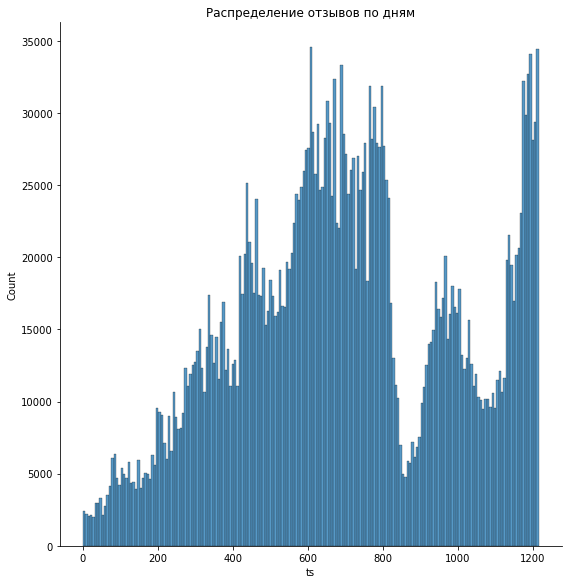

In [178]:
sns.displot(data=reviews, x='ts', height=8)
plt.title('Распределение отзывов по дням')
plt.show()

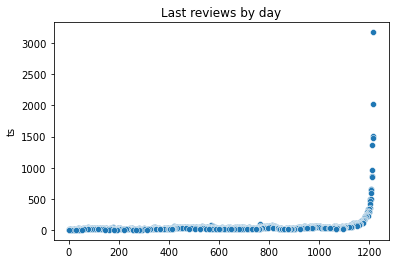

In [186]:
last_reviews = reviews.groupby('org_id')['ts'].max().value_counts()
sns.scatterplot(data=last_reviews)
plt.title('Last reviews by day')
plt.show()

In [ ]:
reviews[reviews.new_org_id.isin(spb_orgs + msk_orgs)].groupby('org_id')['ts'].max()

In [157]:
us_org_pairs = reviews.groupby(['user_id', 'org_id'])['rating'].count()
print(us_org_pairs[us_org_pairs > 1].size, 'number of non unique user-org pairs')
print(us_org_pairs.size, 'number of all unique user-org pairs')
print(us_org_pairs.max(), 'max number of reviews for the same org by one user')
print(reviews.query("org_city != user_city").shape, 'number of different cities user-org pairs')

47631 number of non unique user-org pairs
2961747 number of all unique user-org pairs
2 max number of reviews for the same org by one user
(147444, 10) number of different cities user-org pairs


In [130]:
reviews.query("org_city != user_city")['user_id'].nunique()

89061

In [10]:
print(reviews.user_id.nunique())
print(reviews.query("org_city == 'msk'").org_id.nunique())
print(reviews.query("org_city == 'spb'").org_id.nunique())
non_eq_cities = reviews[reviews.user_city != reviews.org_city]
print(non_eq_cities.query("org_city == 'msk'").org_id.nunique())
print(non_eq_cities.query("org_city == 'spb'").org_id.nunique())

1252800
44229
22176
8891
9691


In [11]:
print(reviews.user_id.nunique())
print(reviews.query("org_city == 'msk'").user_id.nunique())
print(reviews.query("org_city == 'spb'").user_id.nunique())
non_eq_cities = reviews[reviews.user_city != reviews.org_city]
print(non_eq_cities.query("org_city == 'msk'").user_id.nunique())
print(non_eq_cities.query("org_city == 'spb'").user_id.nunique())

1252800
904993
413539
20079
79488


In [26]:
reviews.user_id.value_counts().describe()

count    1.252800e+06
mean     2.906157e+00
std      4.678116e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.850000e+02
Name: user_id, dtype: float64

In [ ]:
reviews.user_id.isin(test_users).value_counts().clip(upper=40).hist(bins=40, figsize=(20, 10))

<AxesSubplot:>

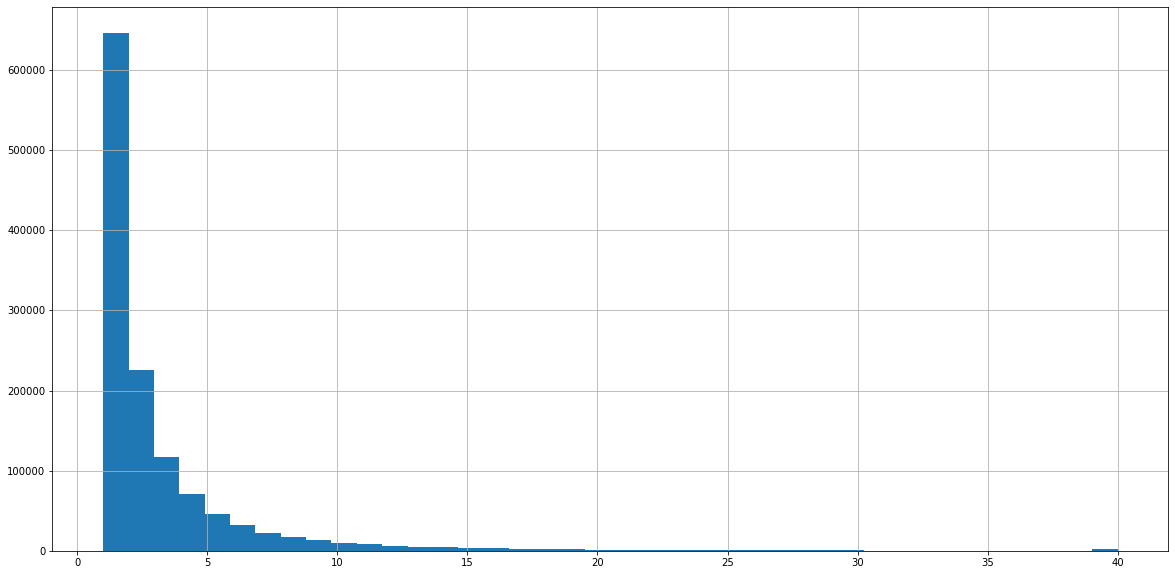

In [25]:
reviews.user_id.value_counts().clip(upper=40).hist(bins=40, figsize=(20, 10))

# Train-test split

In [32]:
def clear_df(df, suffixes=['_x', '_y'], inplace=True):
    '''
    clear_df(df, suffixes=['_x', '_y'], inplace=True)
        Удаляет из входного df все колонки, оканчивающиеся на заданные суффиксы. 
        
        Parameters
        ----------
        df : pandas.DataFrame
        
        suffixies : Iterable, default=['_x', '_y']
            Суффиксы колонок, подлежащих удалению
            
        inplace : bool, default=True
            Нужно ли удалить колонки "на месте" или же создать копию DataFrame.
            
        Returns
        -------
        pandas.DataFrame (optional)
            df с удалёнными колонками
    '''
    
    def bad_suffix(column):
        nonlocal suffixes
        return any(column.endswith(suffix) for suffix in suffixes)
        
    columns_to_drop = [col for col in df.columns if bad_suffix(col)]
    return df.drop(columns_to_drop, axis=1, inplace=inplace)


def extract_unique(reviews, column): 
    '''
    extract_unique(reviews, column)
        Извлекает уникальные значения из колонки в DataFrame.
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            pandas.DataFrame, из которого будут извлечены значения.
        
        column : str
            Имя колонки в <reviews>.
        
        Returns
        -------
        pandas.DataFrame
            Содержит одну именованную колонку с уникальными значениями. 
    '''
    
    unique = reviews[column].unique()
    return pd.DataFrame({column: unique})


def count_unique(reviews, column):
    '''
    count_unique(reviews, column)
        Извлекает и подсчитывает уникальные значения из колонки в DataFrame.
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            pandas.DataFrame, из которого будут извлечены значения.
        
        column : str
            Имя колонки в <reviews>.
        
        Returns
        -------
        pandas.DataFrame
            Содержит две колонки: с уникальными значениями и счётчиком встреченных. 
    '''
    
    return reviews[column].value_counts().reset_index(name='count').rename({'index': column}, axis=1)



def filter_reviews(reviews, users=None, orgs=None): 
    '''
    filter_reviews(reviews, users=None, orgs=None)
    Оставляет в выборке только отзывы, оставленные заданными пользователями на заданные организации. 
    
    Parameters
    ----------
        users: pandas.DataFrame, default=None
            DataFrame, содержащий колонку <user_id>.
            Если None, то фильтрация не происходит. 
            
        orgs: pandas.DataFrame, default=None
            DataFrame, содержащий колонку <org_id>.
            Если None, то фильтрация не происходит. 
    
    Returns
    -------
        pandas.DataFrame
            Отфильтрованная выборка отзывов. 

    '''
    if users is not None: 
        reviews = reviews.merge(users, on='user_id', how='inner')
        clear_df(reviews)
        
    if orgs is not None:
        reviews = reviews.merge(orgs, on='org_id', how='inner')
        clear_df(reviews)
        
    return reviews


def train_test_split(reviews, ts_start, ts_end=None):
    '''
    train_test_split(reviews, ts_start, ts_end=None)
        Разделяет выборку отзывов на две части: обучающую и тестовую. 
        В тестовую выборку попадают только отзывы с user_id и org_id, встречающимися в обучающей выборке.

        Parameters
        ----------
        reviews : pandas.DataFrame 
            Отзывы из reviews.csv с обязательными полями:
                <rating>, <ts>, <user_id>, <user_city>, <org_id>, <org_city>.

        ts_start : int
            Первый день отзывов из тестовой выборки (включительно).

        ts_end : int, default=None
            Последний день отзывов из обучающей выборки (включительно)
            Если параметр равен None, то ts_end == reviews['ts'].max(). 

        Returns
        -------
        splitting : tuple
            Кортеж из двух pandas.DataFrame такой же структуры, как и reviews:
            в первом отзывы, попавшие в обучающую выборку, во втором - в тестовую.
    '''
    
    if not ts_end:
        ts_end = reviews['ts'].max()
    
    
    reviews_train = reviews[(reviews['ts'] < ts_start) | (reviews['ts'] > ts_end)]
    reviews_test = reviews[(ts_start <= reviews['ts']) & (reviews['ts'] <= ts_end)]
    
    # 1. Выбираем только отзывы на понравившиеся места у путешественников
    reviews_test = reviews_test[reviews_test['rating'] >= 4.0]
    reviews_test = reviews_test[reviews_test['user_city'] != reviews_test['org_city']]
    
    # 2. Оставляем в тесте только тех пользователей и организации, которые встречались в трейне
    train_orgs = extract_unique(reviews_train, 'org_id')
    train_users = extract_unique(reviews_train, 'user_id')
    
    reviews_test = filter_reviews(reviews_test, orgs=train_orgs)

    return reviews_train, reviews_test


def process_reviews(reviews):
    '''
    process_reviews(reviews)
        Извлекает из набора отзывов тестовых пользователей и таргет. 
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            DataFrame с отзывами, содержащий колонки <user_id> и <org_id>
        
        Returns
        -------
        X : pandas.DataFrame
            DataFrame такой же структуры, как и в test_users.csv
            
        y : pandas.DataFrame
            DataFrame с колонками <user_id> и <target>. 
            В <target> содержится список org_id, посещённых пользователем. 
    '''
    
    y = reviews.groupby('user_id')['org_id'].apply(list).reset_index(name='target')
    X = pd.DataFrame(y['user_id'])
    
    return X, y

In [8]:
reviews['ts'].max()

1216

Всего в выборку попали отызывы за **1216** дней. 

Отложим в тестовую выборку отзывы за последние **100** дней.

In [9]:
train_reviews, test_reviews = train_test_split(reviews, 1116)
X_test, y_test = process_reviews(test_reviews)

Посмотрим, сколько всего уникальных пользователей попало в эту тестовую выборку:

In [10]:
len(X_test)

12044

# Метрика

Метрика принимает на вход два DataFrame, имеющих такую же структуру, как и **y_test**.

`print_score` домножает реальное значение метрики на 100 так же, как и в контесте.

Подобная имплементация используется для оценки **submission**.

In [33]:
def get_recall(y_true, predictions, size=20):
        '''
        Calculates recall at `size`
            
            Parameters
            ----------
            y_true : pd.DataFrame
                DataFrame с колонками <user_id> и <target>. 
                В <target> содержится список настоящих org_id, посещённых пользователем. 
                
            predictions : pd.DataFrame
                DataFrame с колонками <user_id> и <target>. 
                В <target> содержится список рекомендованных для пользователя org_id.
                
            Returns
            -------
            float 
                Значение метрики.
        '''
        
        y_true = y_true.rename({'target': 'y_true'}, axis='columns')
        predictions = predictions.rename({'target': 'predictions'}, axis='columns')
        
        merged = y_true.merge(predictions, left_on='user_id', right_on='user_id')
        merged['intersection'] = merged.apply(
            lambda row: np.intersect1d(row['y_true'], row['predictions'][:size]).size,
            axis=1
        )
        merged['cardinality'] = merged['y_true'].apply(len)
        merged['recall'] = merged['intersection'] / merged['cardinality']
        return merged['recall'].mean()

def MNAP(size=20):
    '''
    MNAP(size=20)
        Создаёт метрику под <size> сделанных предсказаний.
        
        Parameters
        ----------
        size : int, default=20
            Размер рекомендованной выборки для каждого пользователя
        
        Returns
        -------
        func(pd.DataFrame, pd.DataFrame) -> float
            Функция, вычисляющая MNAP.
        
    '''
    
    assert size >= 1, "Size must be greater than zero!"
    
    def metric(y_true, predictions, size=size):
        '''
        metric(y_true, predictions, size=size)
            Метрика MNAP для двух перемешанных наборов <y_true> и <y_pred>.
            
            Parameters
            ----------
            y_true : pd.DataFrame
                DataFrame с колонками <user_id> и <target>. 
                В <target> содержится список настоящих org_id, посещённых пользователем. 
                
            predictions : pd.DataFrame
                DataFrame с колонками <user_id> и <target>. 
                В <target> содержится список рекомендованных для пользователя org_id.
                
            Returns
            -------
            float 
                Значение метрики.
        '''
        
        y_true = y_true.rename({'target': 'y_true'}, axis='columns')
        predictions = predictions.rename({'target': 'predictions'}, axis='columns')
        
        merged = y_true.merge(predictions, left_on='user_id', right_on='user_id')
    
        def score(x, size=size):
            '''
            Вспомогательная функция.
            '''
            
            
            y_true = x[1][1]
            predictions = x[1][2][:size]
            
            weight = 0
            
            inner_weights = [0]
            for n, item in enumerate(predictions):
                inner_weight = inner_weights[-1] + (1 if item in y_true else 0)
                inner_weights.append(inner_weight)
            
            for n, item in enumerate(predictions):                
                if item in y_true:
                    weight += inner_weights[n + 1] / (n + 1)
                    
            return weight / min(len(y_true), size)
    
        return np.mean([score(row) for row in merged.iterrows()])
    
        
    return metric


def print_score(score):
    print(f"Score: {score*100.0:.2f}")
    
    
N = 20
MNAP_N = MNAP(N)

# Подходы без машинного обучения

## Случайные N мест

Попробуем предлагать пользователям случайные места из другого города. 

In [12]:
spb_orgs = orgs[orgs['city'] == 'spb']['org_id']
msk_orgs = orgs[orgs['city'] == 'msk']['org_id']

test_users_with_locations = X_test.merge(users, on='user_id')

In [13]:
%%time

np.random.seed(1337)
choose = lambda x: np.random.choice(spb_orgs, N) if x['city'] == 'msk' else np.random.choice(msk_orgs, N)
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 0.02
CPU times: user 2.2 s, sys: 59.9 ms, total: 2.26 s
Wall time: 2.22 s


## N самых популярных мест

Предыдущий подход, очевидно, не очень удачно предсказывает, какие места посетит пользователей. 

Попробуем улучшить стратегию: будем предлагать пользователям самые популярные места, то есть те, на которые оставлено больше всего отзывов. 

In [14]:
msk_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'msk')]['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'spb')]['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [15]:
%%time

choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 4.21
CPU times: user 637 ms, sys: 9.89 ms, total: 647 ms
Wall time: 647 ms


Отлично, метрика немного улучшилась. Но стоит попробовать доработать эту тактику. 

## N самых популярных мест среди туристов

In [16]:
tourist_reviews = train_reviews[train_reviews['rating'] >= 4.0]

# набор отзывов только от туристов
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [17]:
%%time

choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 6.40
CPU times: user 652 ms, sys: 5.35 ms, total: 657 ms
Wall time: 657 ms


Метрика улучшилась ещё немного.

## N / rubrics_count самых популярных мест из каждой рубрики

In [18]:
def extract_top_by_rubrics(reviews, N):
    '''
    extract_top_by_rubrics(reviews, N)
        Набирает самые популярные организации по рубрикам, сохраняя распределение.
        
        Parameters
        ----------
        reviews : pd.DataFrame
            Отзывы пользователей для рекомендации.
            
        N : int
            Число рекомендаций.
        
        Returns
        -------
        orgs_list : list
            Список отобранных организаций.
    '''
    
    # извлечение популярных рубрик
    reviews = reviews.merge(orgs, on='org_id')[['org_id', 'rubrics_id']]
    
    rubrics = reviews.explode('rubrics_id').groupby('rubrics_id').size()
    rubrics = (rubrics / rubrics.sum() * N).apply(round).sort_values(ascending=False)

    # вывод списка рубрик по убыванию популярности
#     print(
#         pd.read_csv('data/rubrics.csv')
#         .merge(rubrics.reset_index(), left_index=True, right_on='rubrics_id')
#         .sort_values(by=0, ascending=False)[['rubric_id', 0]]
#     )
    
    # извлечение популярных организаций
    train_orgs = reviews.groupby('org_id').size().reset_index(name='count').merge(orgs, on='org_id')
    train_orgs = train_orgs[['org_id', 'count', 'rubrics_id']]

    most_popular_rubric = lambda rubrics_id: max(rubrics_id, key=lambda rubric_id: rubrics[rubric_id])
    train_orgs['rubrics_id'] = train_orgs['rubrics_id'].apply(most_popular_rubric)
    
    orgs_by_rubrics = train_orgs.sort_values(by='count', ascending=False).groupby('rubrics_id')['org_id'].apply(list)
    
    # соберём самые популярные организации в рубриках в один список
    
    orgs_list = []

    for rubric_id, count in zip(rubrics.index, rubrics):
        if rubric_id not in orgs_by_rubrics:
            continue 

        orgs_list.extend(orgs_by_rubrics[rubric_id][:count])
    
    return orgs_list


msk_orgs = extract_top_by_rubrics(tourist_reviews[tourist_reviews['org_city'] == 'msk'], N)
spb_orgs = extract_top_by_rubrics(tourist_reviews[tourist_reviews['org_city'] == 'spb'], N)

In [19]:
%%time

choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 5.77
CPU times: user 642 ms, sys: 5 ms, total: 647 ms
Wall time: 647 ms


# Время ML! Коллаборативная фильтрация

## Memory-based

Для этой группы методов требуется явное построение матрицы __пользователь-организация__ (__interaction matrix__), где на пересечении $i$-ой строки и $j$-ого столбца будет рейтинг, который $i$-ый пользователь выставил $j$-ой организации или же пропуск, если рейтинг не был установлен. 

In [20]:
def reduce_reviews(reviews, min_user_reviews=5, min_org_reviews=13):
    '''
    reduce_reviews(reviews, min_user_reviews=5, min_org_reviews=13)
        Убирает из выборки пользователей и организации, у которых менее <min_reviews> отзывов в родном городе. 
        Оставляет только отзывы туристов. 
        
        Parameters
        ----------
        reviews : pandas.DataFrame 
            Выборка отзывов с обязательными полями:
                <user_id>, <user_city>.
        
        min_user_reviews : int, default=5
            Минимальное количество отзывов у пользователя, необходимое для включения в выборку.
            
        min_org_reviews : int, default=13
            Минимальное количество отзывов у организации, необходимое для включения в выборку.
            
        Returns
        -------
        splitting : tuple
            Кортеж из двух наборов.
            Каждый набор содержит 2 pandas.DataFrame:
                1. Урезанная выборка отзывов
                2. Набор уникальных организаций
                
            Первый набор содержит DataFrame-ы, относящиеся к отзывам, оставленным в родном городе, а второй -
            к отзывам, оставленным в чужом городе. ё
            
        users : pd.DataFrame
            Набор уникальных пользователей в выборке
        
    '''
    
    inner_reviews = reviews[reviews['user_city'] == reviews['org_city']]
    outer_reviews = reviews[reviews['user_city'] != reviews['org_city']]

    # оставляем только отзывы туристов на родной город 
    tourist_users = extract_unique(outer_reviews, 'user_id')
    inner_reviews = filter_reviews(inner_reviews, users=tourist_users)
    
    # выбираем только тех пользователей и организации, у которых есть <min_reviews> отзывов
    top_users = count_unique(inner_reviews, 'user_id')
    top_users = top_users[top_users['count'] >= min_user_reviews]
        
    top_orgs = count_unique(inner_reviews, 'org_id')
    top_orgs = top_orgs[top_orgs['count'] >= min_org_reviews]
        
    inner_reviews = filter_reviews(inner_reviews, users=top_users, orgs=top_orgs)
    outer_reviews = filter_reviews(outer_reviews, users=top_users)
    
    # combine reviews
    reviews = pd.concat([inner_reviews, outer_reviews])
    users = extract_unique(reviews, 'user_id')
    orgs = extract_unique(reviews, 'org_id')
    
    
    return (
        (
            inner_reviews,
            extract_unique(inner_reviews, 'org_id')
        ),
        (
            outer_reviews,
            extract_unique(outer_reviews, 'org_id')
        ),
        extract_unique(inner_reviews, 'user_id')
    )

In [21]:
def create_mappings(df, column):
    '''
    create_mappings(df, column)
        Создаёт маппинг между оригинальными ключами словаря и новыми порядковыми.
        
        Parameters
        ----------
        df : pandas.DataFrame
            DataFrame с данными.
            
        column : str
            Название колонки, содержащей нужны ключи. 
        
        Returns
        -------
        code_to_idx : dict
            Словарь с маппингом: "оригинальный ключ" -> "новый ключ".
        
        idx_to_code : dict
            Словарь с маппингом: "новый ключ" -> "оригинальный ключ".
    '''
    
    code_to_idx = {}
    idx_to_code = {}
    
    for idx, code in enumerate(df[column].to_list()):
        code_to_idx[code] = idx
        idx_to_code[idx] = code
        
    return code_to_idx, idx_to_code


def map_ids(row, mapping):
    '''
    Вспомогательная функция
    '''
    
    return mapping[row]


def interaction_matrix(reviews, test_users, min_user_reviews=5, min_org_reviews=12): 
    '''
    interaction_matrix(reviews, test_users, min_user_reviews=5, min_org_reviews=12)
        Создаёт блочную матрицу взаимодействий (вид матрицы описан в Returns)
        
        Parameters
        ----------
        reviews : pd.DataFrame
            Отзывы пользователей для матрицы взаимодействий.
            
        test_users : pd.DataFrame
            Пользователи, для которых будет выполнятся предсказание. 
        
        min_user_reviews : int, default=5
            Минимальное число отзывов от пользователя, необходимое для включения его в матрицу.
        
        min_org_reviews : int, default=12
            Минимальное число отзывов на организацию, необходимое для включения её в матрицу.
    
        Returns
        -------
        InteractionMatrix : scipy.sparse.csr_matrix
            Матрица, содержащая рейтинги, выставленные пользователями.
            Она блочная и имеет такой вид:
                 ---------------------------------------------------
                | TRAIN USERS, INNER ORGS | TRAIN USERS, OUTER ORGS |
                |                         |                         |
                 ---------------------------------------------------
                |  TEST USERS, INNER ORGS |  TEST USERS, OUTER ORGS |
                |                         |                         |
                 ---------------------------------------------------

        splitting : tuple
            Кортеж, содержащий два целых числа: 
                1. Число пользователей в обучающей выборке 
                2. Число организаций в домашнем регионе

        splitting: tuple
            Кортеж, содержащий два котрежа из двух словарей:
                1. (idx_to_uid, uid_to_idx) - содержит маппинг индекса к user_id
                2. (idx_to_oid, oid_to_idx) - содержит маппинг индекса к org_id
    '''
    
    
    info = reduce_reviews(train_reviews, min_user_reviews, min_org_reviews)
    (inner_reviews, inner_orgs), (outer_reviews, outer_orgs), train_users = info
    
    # удалим из обучающей выборки пользователей, которые есть в тестовой
    test_users = test_users[['user_id']]
    
    train_users = (
        pd.merge(train_users, test_users, indicator=True, how='outer')
        .query('_merge=="left_only"')
        .drop('_merge', axis=1)
    )
    
    inner_reviews = filter_reviews(inner_reviews, train_users)
    outer_reviews = filter_reviews(outer_reviews, train_users)
    
    # оставляем отзывы, оставленные тестовыми пользователями
    test_reviews = filter_reviews(reviews, test_users, pd.concat([inner_orgs, outer_orgs]))
    
    # получаем полный набор маппингов
    all_users = pd.concat([train_users, test_users])
    all_orgs = pd.concat([inner_orgs, outer_orgs])
    
    uid_to_idx, idx_to_uid = create_mappings(all_users, 'user_id')
    oid_to_idx, idx_to_oid = create_mappings(all_orgs, 'org_id')
    
    # собираем матрицу взаимодействий 
    reviews = pd.concat([inner_reviews, outer_reviews, test_reviews])    
        
    I = reviews['user_id'].apply(map_ids, args=[uid_to_idx]).values
    J = reviews['org_id'].apply(map_ids, args=[oid_to_idx]).values
    values = reviews['rating']
        
    interactions = sparse.coo_matrix(
        (values, (I, J)), 
        shape=(len(all_users), len(all_orgs)), 
        dtype=np.float64
    ).tocsr()
    
    
    return (
        interactions, 
        (len(train_users), len(inner_orgs)), 
        (
            (idx_to_uid, uid_to_idx),
            (idx_to_oid, oid_to_idx)
        )
    )

## ALS

In [22]:
%%time


import implicit


def make_predictions(interactions, X_test, N):
    '''
    make_predictions(interactions, X_test, N)
        Делает рекомендации для пользователей из <X_test> на основе матрицы взаимодействий. 
        
        Parameters
        ----------
        interactions : scipy.sparse.csr_matrix
            Разреженная матрица взаимодействий.
            
        X_test : pd.DataFrame
            Набор тестовых пользователей, для которых нужно сделать рекомендации. 
        
        N : int
            Число рекомендаций для каждого пользователя. 
        
        Returns
        -------
        predictions : pd.DataFrame
            DataFrame с колонками <user_id> и <target>. 
            В <target> содержится список рекомендованных для пользователя org_id.
        
        
    '''
    
    predictions = X_test[['user_id']].copy()
    predictions['target'] = pd.Series(dtype=object)
    predictions = predictions.set_index('user_id')
    
    interactions, (train_users_len, inner_orgs_len), mappings = interactions
    (idx_to_uid, uid_to_idx), (idx_to_oid, oid_to_idx) = mappings

    base_model = implicit.als.AlternatingLeastSquares(
        factors=5, 
        iterations=75, 
        regularization=0.05, 
        random_state=42
    )
    
    base_model.fit(interactions.T)
    
    orgs_to_filter = list(np.arange(inner_orgs_len))

    recommendations = base_model.recommend_all(
        interactions,
        N=N,
        filter_already_liked_items=True,
        filter_items=orgs_to_filter,
        show_progress=True
    )
    
    for user_id in tqdm(X_test['user_id'].values, leave=False):
        predictions.loc[user_id, 'target'] = list(
            map(
                lambda org_idx: idx_to_oid[org_idx], 
                recommendations[uid_to_idx[user_id]]
            )
        )
        
    return predictions.reset_index()


msk_interactions = interaction_matrix(
    train_reviews[train_reviews['user_city'] == 'msk'],
    test_users_with_locations[test_users_with_locations['city'] == 'msk'],
)

spb_interactions = interaction_matrix(
    train_reviews[train_reviews['user_city'] == 'spb'],
    test_users_with_locations[test_users_with_locations['city'] == 'spb'],
)       
        
test_msk_users = test_users_with_locations[test_users_with_locations['city'] == 'msk']
test_spb_users = test_users_with_locations[test_users_with_locations['city'] == 'spb']

msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/32242 [00:00<?, ?it/s]

  0%|          | 0/9545 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/25789 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

CPU times: user 1min 52s, sys: 1.97 s, total: 1min 54s
Wall time: 34.6 s


In [23]:
%%time

print_score(MNAP_N(y_test, predictions))

Score: 0.85
CPU times: user 592 ms, sys: 12.3 ms, total: 604 ms
Wall time: 607 ms


# Submission

Выберем лучший метод на валидации, переобучим его на всей выборке и сделаем предсказание на тестовой выборке. 

## Without ML

In [345]:
tourist_reviews.query('ts >= 1216 - 500')

,user_id,org_id,rating,ts,aspects,user_city,new_user_id,org_city,new_org_id,is_tourist
508509,3469137883208648792,14814427257061788801,5.0,716,NaN,msk,225715,spb,16392,True
306094,2077243727176024954,12308351802699428940,5.0,716,NaN,spb,993368,msk,8058,True
2484802,7242014912683578525,882341785564248463,5.0,716,NaN,spb,961726,msk,1505,True
2698933,1235742476129319798,8754537469956388818,5.0,716,NaN,msk,130143,spb,17695,True
1945682,4903130228688467019,12356446065909013046,5.0,716,NaN,msk,804304,spb,60378,True
...,...,...,...,...,...,...,...,...,...,...
3462302,9734114747371159128,8093959286536165301,5.0,1216,NaN,msk,381425,spb,55452,True
3561222,5538454390288703636,5868790891175779865,5.0,1216,"[279, 301]",msk,623766,spb,35519,True
325629,4292291913942749620,5002407858008059043,5.0,1216,NaN,msk,338088,spb,13349,True
3123284,6875142702013331804,18297038156563999564,5.0,1216,"[4, 6]",msk,831458,spb,58474,True


In [346]:
# набор отзывов только от туристов
tourist_reviews = reviews[reviews['rating'] >= 4.0]
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]
tourist_reviews = tourist_reviews.query('ts >= 1216 - 500')
# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()


msk_orgs = str(' '.join(map(str, msk_orgs)))
spb_orgs = str(' '.join(map(str, spb_orgs)))

In [347]:
test_users = pd.read_csv('data/test_users.csv')
test_users['city'] = test_users.merge(users, on='user_id')['city']

In [348]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users.apply(choose, axis=1)

predictions = test_users[['user_id']]
predictions['target'] = target

predictions.head()

,user_id,target
0,3545210947248911048,12046097390037935713 5002407858008059043 68382...
1,15271987121288045390,12046097390037935713 5002407858008059043 68382...
2,15016858616184265932,12046097390037935713 5002407858008059043 68382...
3,12457244142928722989,12046097390037935713 5002407858008059043 68382...
4,13339684649926251468,15250345250621165867 9104453017196776235 15684...


In [350]:
predictions.to_csv('sumbission1.csv', index=None)

## With ML

In [28]:
test_users = pd.read_csv('data/test_users.csv')
test_users = test_users.merge(users, on='user_id')


test_msk_users = test_users[test_users['city'] == 'msk'][['user_id', 'city']]
test_spb_users = test_users[test_users['city'] == 'spb'][['user_id', 'city']]


msk_interactions = interaction_matrix(
    reviews[reviews['user_city'] == 'msk'],
    test_msk_users
)

spb_interactions = interaction_matrix(
    reviews[reviews['user_city'] == 'spb'],
    test_spb_users
)

msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/36615 [00:00<?, ?it/s]

  0%|          | 0/14638 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/25547 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

In [29]:
predictions['target'] = predictions['target'].apply(lambda orgs: ' '.join(map(str, orgs)))
predictions.head()

,user_id,target
0,3545210947248911048,10899892390879739444 6556420723466820988 12320...
1,15271987121288045390,6755179149394338096 4264897535035612511 133612...
2,15016858616184265932,7034326954454250932 14180000520266438941 12018...
3,12457244142928722989,7034326954454250932 15250345250621165867 12018...
4,16511650156158419042,10899892390879739444 1232005279283743070 15250...


In [30]:
predictions.to_csv('answers_ml.csv', index=None)